In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
import helper
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


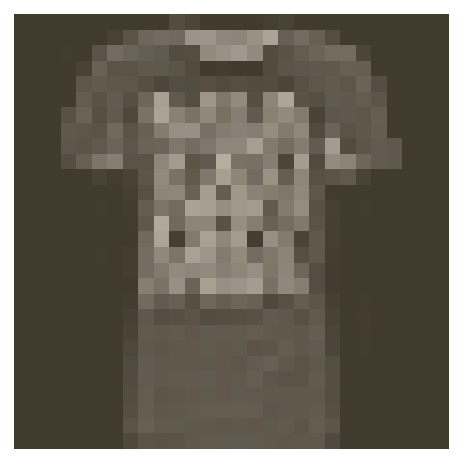

In [4]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.log_softmax(self.fc4(x), dim=1)
        
        return x


In [6]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 20

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 모델에서 훈련
        result = model(images)
        # 오차 계산
        loss = criterion(result, labels)
        
        # 초기화
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 스텝
        optimizer.step()
        
        # 오차값을 총 오차에 더함
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")


Training loss: 0.5170871927412842
Training loss: 0.3914865124533807
Training loss: 0.35631317987656796
Training loss: 0.33137258636290584
Training loss: 0.31669758261838704
Training loss: 0.3030032585662947
Training loss: 0.2894662113300265
Training loss: 0.283583628406911
Training loss: 0.27549251487482584
Training loss: 0.25974820764350104
Training loss: 0.2593495695313602
Training loss: 0.2523235815769828
Training loss: 0.24344871101825477
Training loss: 0.24404824177212298
Training loss: 0.23867870717923015
Training loss: 0.2358535521649825
Training loss: 0.22728033716490528
Training loss: 0.22334893488648858
Training loss: 0.21305817310045014
Training loss: 0.21304548505161489


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
img = img.resize_(1, 784)
ps = torch.exp(model(img))
#view_classify(img.resize_(1, 28, 28), ps, version='Fashion')

In [8]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    # for 문이 끝나면 실행한다.
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        # 자동 미분을 꺼서 pytorch가 쓸 떼 없는 짓을 안하게 한다. (어차피 test set에서 하는 작업이므로)
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                # 로그 확률에 지수 적용
                ps = torch.exp(log_ps)
                # topk는 k번째로 큰 숫자를 찾아내는 것이다.
                # dim=1 는 dimension을 의미한다.
                top_p, top_class = ps.topk(1, dim=1)
                # labels를 top_class와 똑같은 형태로 만든다음에, 얼마나 같은게 있는지 확인한다.
                equals = top_class == labels.view(*top_class.shape)
                # equals를 float으로 바꾸고 평균 정확도를 구한다.
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 0.514..  Test Loss: 0.457..  Test Accuracy: 0.833
Epoch: 2/30..  Training Loss: 0.390..  Test Loss: 0.434..  Test Accuracy: 0.845
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.388..  Test Accuracy: 0.864
Epoch: 4/30..  Training Loss: 0.338..  Test Loss: 0.374..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.318..  Test Loss: 0.383..  Test Accuracy: 0.864
Epoch: 6/30..  Training Loss: 0.302..  Test Loss: 0.397..  Test Accuracy: 0.863
Epoch: 7/30..  Training Loss: 0.292..  Test Loss: 0.355..  Test Accuracy: 0.874
Epoch: 8/30..  Training Loss: 0.278..  Test Loss: 0.366..  Test Accuracy: 0.872
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.376..  Test Accuracy: 0.873
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.360..  Test Accuracy: 0.874
Epoch: 11/30..  Training Loss: 0.260..  Test Loss: 0.393..  Test Accuracy: 0.873
Epoch: 12/30..  Training Loss: 0.252..  Test Loss: 0.393..  Test Accuracy: 0.866
Epoch: 13/30..  Training Loss: 0.250.

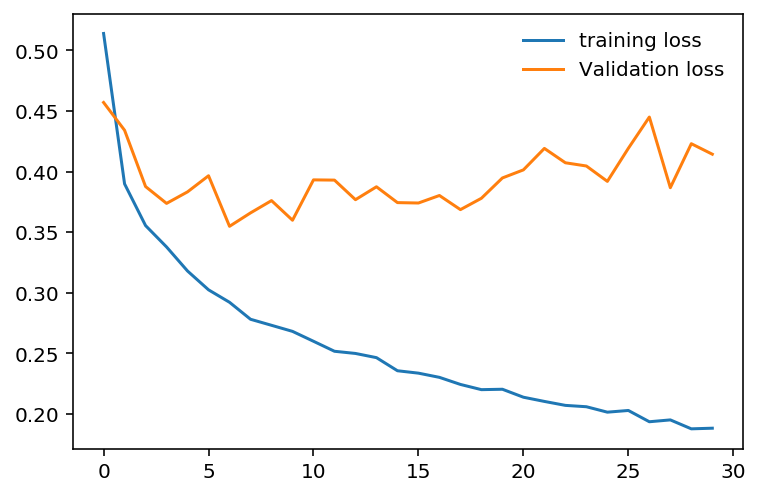

In [9]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [10]:
#dropout

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # 0.2정도를 무작위로 골라 dropout한다.
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.dropout(nn.functional.relu(self.fc3(x)))

        # output은 dropout하면 안된다..
        x = nn.functional.log_softmax(self.fc4(x), dim=1)

        return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # 다시 트레이닝 과정으로 돌아간다.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.607..  Test Loss: 0.492..  Test Accuracy: 0.813
Epoch: 2/30..  Training Loss: 0.483..  Test Loss: 0.453..  Test Accuracy: 0.828
Epoch: 3/30..  Training Loss: 0.456..  Test Loss: 0.424..  Test Accuracy: 0.843
Epoch: 4/30..  Training Loss: 0.433..  Test Loss: 0.402..  Test Accuracy: 0.854
Epoch: 5/30..  Training Loss: 0.423..  Test Loss: 0.414..  Test Accuracy: 0.848
Epoch: 6/30..  Training Loss: 0.413..  Test Loss: 0.405..  Test Accuracy: 0.858
Epoch: 7/30..  Training Loss: 0.407..  Test Loss: 0.391..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.399..  Test Loss: 0.418..  Test Accuracy: 0.859
Epoch: 9/30..  Training Loss: 0.403..  Test Loss: 0.394..  Test Accuracy: 0.863
Epoch: 10/30..  Training Loss: 0.386..  Test Loss: 0.390..  Test Accuracy: 0.859
Epoch: 11/30..  Training Loss: 0.389..  Test Loss: 0.394..  Test Accuracy: 0.865
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.376..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.371.

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)